In [2]:
import sys
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.spatial.distance import squareform

plt.style.use('bmh')
%matplotlib inline

try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

class KnnDtw(object):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays
    
    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for KNN
        
    max_warping_window : int, optional (default = infinity)
        Maximum warping window allowed by the DTW dynamic
        programming function
            
    subsample_step : int, optional (default = 1)
        Step size for the timeseries array. By setting subsample_step = 2,
        the timeseries length will be reduced by 50% because every second
        item is skipped. Implemented by x[:, ::subsample_step]
    """
    
    def __init__(self, n_neighbors=5, max_warping_window=10000, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    
    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
            Training data set for input into KNN classifer
            
        l : array of shape [n_samples]
            Training labels for input into KNN classifier
        """
        
        self.x = x
        self.l = l
        
    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
        """Returns the DTW similarity distance between two 2-D
        timeseries numpy arrays.

        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
            Two arrays containing n_samples of timeseries data
            whose DTW distance between each sample of A and B
            will be compared
        
        d : DistanceMetric object (default = abs(x-y))
            the distance measure used for A_i - B_j in the
            DTW dynamic programming function
        
        Returns
        -------
        DTW distance between A and B
        """

        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = sys.maxsize * np.ones((M, N))

        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in range(1, M):
            cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

        for j in range(1, N):
            cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),
                            min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

        # Return DTW distance given window 
        return cost[-1, -1]
    
    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        
        y : array of shape [n_samples, n_timepoints]
        
        Returns
        -------
        Distance matrix between each item of x and y with
            shape [training_n_samples, testing_n_samples]
        """
        
        # Compute the distance matrix        
        dm_count = 0
        
        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if(np.array_equal(x, y)):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            
            p = ProgressBar(shape(dm)[0])
            
            for i in range(0, x_s[0] - 1):
                for j in range(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],
                                                      y[j, ::self.subsample_step])
                    
                    dm_count += 1
                    p.animate(dm_count)
            
            # Convert to squareform
            dm = squareform(dm)
            return dm
        
        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0])) 
            dm_size = x_s[0]*y_s[0]
            
            p = ProgressBar(dm_size)
        
            for i in range(0, x_s[0]):
                for j in range(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],
                                                  y[j, ::self.subsample_step])
                    # Update progress bar
                    dm_count += 1
                    p.animate(dm_count)
        
            return dm
        
    def predict(self, x):
        """Predict the class labels or probability estimates for 
        the provided data

        Arguments
        ---------
          x : array of shape [n_samples, n_timepoints]
              Array containing the testing data set to be classified
          
        Returns
        -------
          2 arrays representing:
              (1) the predicted class labels 
              (2) the knn label count probability
        """
        
        dm = self._dist_matrix(x, self.x)

        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]
        
        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1]/self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()

class ProgressBar:
    """This progress bar was taken from PYMC
    """
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython

    def animate_ipython(self, iter):
        print ('\r', self,
        sys.stdout.flush())
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)

Measuring DTW distance 

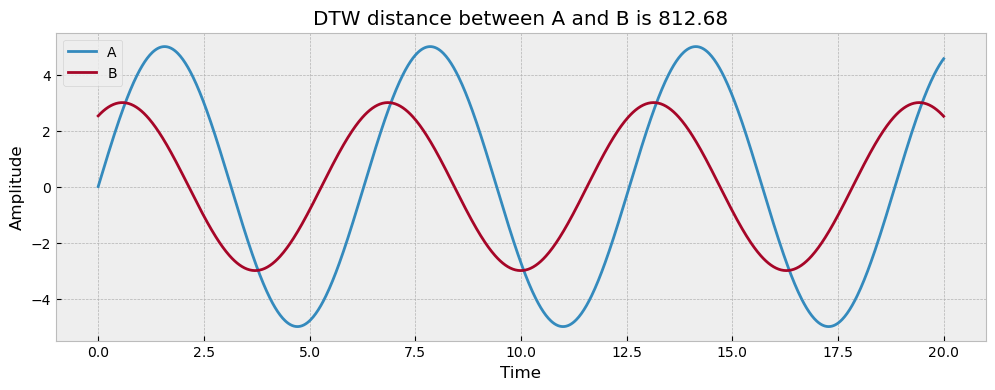

In [2]:
time = np.linspace(0,20,1000)
amplitude_a = 5*np.sin(time)
amplitude_b = 3*np.sin(time + 1)

m = KnnDtw()
distance = m._dtw_distance(amplitude_a, amplitude_b)

fig = plt.figure(figsize=(12,4))
_ = plt.plot(time, amplitude_a, label='A')
_ = plt.plot(time, amplitude_b, label='B')
_ = plt.title('DTW distance between A and B is %.2f' % distance)
_ = plt.ylabel('Amplitude')
_ = plt.xlabel('Time')
_ = plt.legend()

In [14]:
# Import the HAR dataset
x_train_file = open('UCI HAR Dataset/train/Inertial Signals/body_acc_z_train.txt', 'r')
y_train_file = open('UCI HAR Dataset/train/y_train.txt', 'r')

x_test_file = open('UCI HAR Dataset/test/Inertial Signals/body_acc_z_test.txt', 'r')
y_test_file = open('UCI HAR Dataset/test/y_test.txt', 'r')

# Create empty lists
x_train = []
y_train = []
x_test = []
y_test = []

# Mapping table for classes
labels = {1:'WALKING', 2:'WALKING UPSTAIRS', 3:'WALKING DOWNSTAIRS',
          4:'SITTING', 5:'STANDING', 6:'LAYING'}

# Loop through datasets
for x in x_train_file:
    x_train.append([float(ts) for ts in x.split()])
    
for y in y_train_file:
    y_train.append(int(y.rstrip('\n')))
    
for x in x_test_file:
    x_test.append([float(ts) for ts in x.split()])
    
for y in y_test_file:
    y_test.append(int(y.rstrip('\n')))
    
# Convert to numpy for efficiency
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [15]:
print(x_train.shape)

(7352, 128)


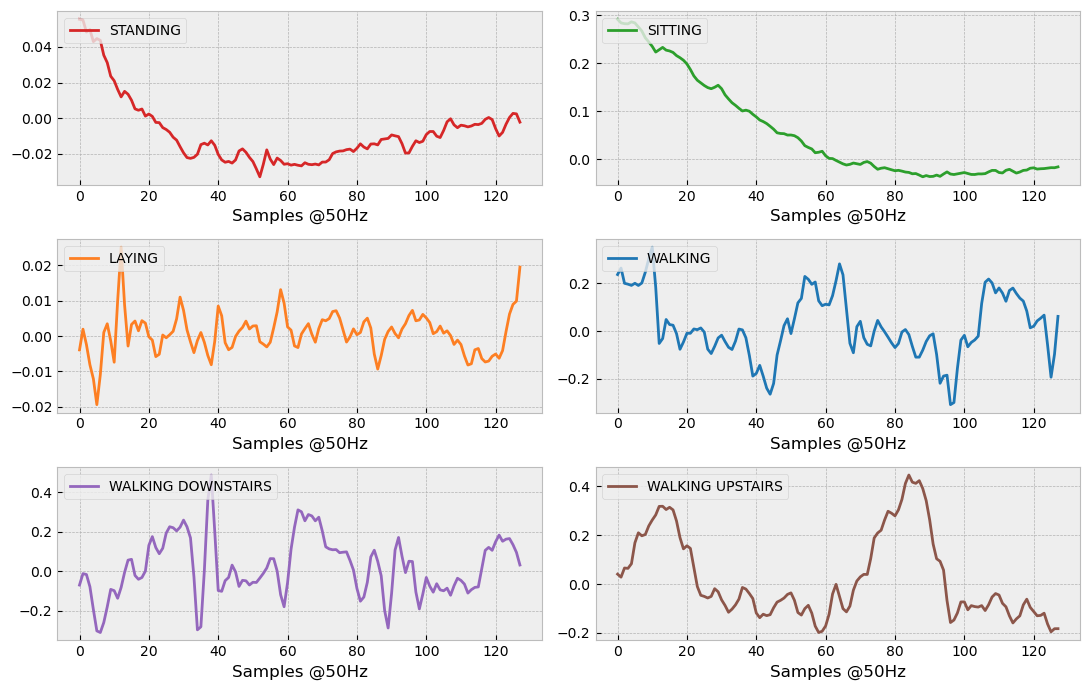

In [18]:
plt.figure(figsize=(11,7))
colors = ['#D62728','#2C9F2C','#FD7F23','#1F77B4','#9467BD',
          '#8C564A','#7F7F7F','#1FBECF','#E377C2','#BCBD27']

for i, r in enumerate([0,27,65,100,145,172]):
    plt.subplot(3,2,i+1)
    plt.plot(x_train[r][:1000], label=labels[y_train[r]], color=colors[i], linewidth=2)
    plt.xlabel('Samples @50Hz')
    plt.legend(loc='upper left')
    plt.tight_layout()

In [17]:
plt.figure

<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

In [1]:
x_train[0].shape

NameError: name 'x_train' is not defined

In [9]:
num = 40
m = KnnDtw(n_neighbors=1, max_warping_window=10)
m.fit(x_train[::num], y_train[::num])
label, proba = m.predict(x_test[::num])

 [                  0%                  ] None
 [                  0%                  ]  2 of 13616 complete None
 [                  0%                  ]  3 of 13616 complete None
 [                  0%                  ]  4 of 13616 complete None
 [                  0%                  ]  5 of 13616 complete None
 [                  0%                  ]  6 of 13616 complete None
 [                  0%                  ]  7 of 13616 complete None
 [                  0%                  ]  8 of 13616 complete None
 [                  0%                  ]  9 of 13616 complete None
 [                  0%                  ]  10 of 13616 complete None
 [                  0%                  ]  11 of 13616 complete None
 [                  0%                  ]  12 of 13616 complete None
 [                  0%                  ]  13 of 13616 complete None
 [                  0%                  ]  14 of 13616 complete None
 [                  0%                  ]  15 of 13616 complete 

C:\Users\aikyn\AppData\Local\Temp\ipykernel_6220\3586895474.py:183: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_data = mode(knn_labels, axis=1)


                    precision    recall  f1-score   support

           WALKING       0.64      0.64      0.64        11
  WALKING UPSTAIRS       0.86      0.86      0.86        14
WALKING DOWNSTAIRS       0.64      0.64      0.64        11
           SITTING       0.33      0.27      0.30        15
          STANDING       0.17      0.18      0.17        11
            LAYING       0.29      0.33      0.31        12

          accuracy                           0.49        74
         macro avg       0.49      0.49      0.48        74
      weighted avg       0.49      0.49      0.49        74



C:\Users\aikyn\AppData\Local\Temp\ipykernel_6220\2341433299.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = fig.colorbar(res)


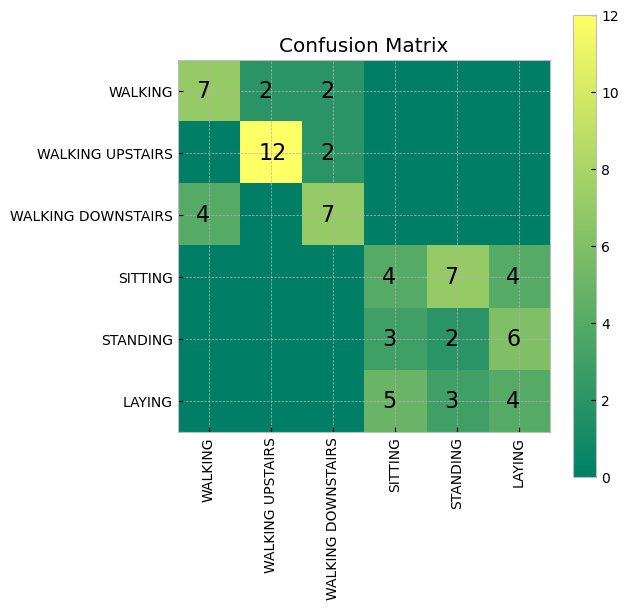

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(label, y_test[::num],target_names=[l for l in labels.values()]))

conf_mat = confusion_matrix(label, y_test[::num])

fig = plt.figure(figsize=(6,6))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)
            
cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(6), [l for l in labels.values()], rotation=90)
_ = plt.yticks(range(6), [l for l in labels.values()])